In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sco
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
# performance measures
def annual_return(r):
    years = (r.index[-1] - r.index[0]).days / 365.25
    return (1 + r).product() ** (1/years) - 1


def total_return(r):
    return (1 + r).prod() - 1


def annual_volatility(r):
    return np.sqrt(252) * r.std()


def sharpe_ratio(r):
    return np.sqrt(252) * r.mean() / r.std()


# drawdown is value today relative to previous max value
def drawdown(r):
    value = (1 + r).cumprod()
    return value / value.cummax() - 1


def max_drawdown(r):
    return drawdown(r).min()


def calmar_ratio(r):
    return annual_return(r) / np.abs(max_drawdown(r))


def sortino_ratio(r):
    negr = r.loc[r < 0]
    return np.sqrt(252) * r.mean() / negr.std()

In [5]:
brk = yf.download(tickers = 'BRK-A', session = session)

brk_monthly = brk.resample('M').last()
brk_monthly['ret'] = brk_monthly['Adj Close'].pct_change()
brk_monthly

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
1980-03-31,270.0000,280.0000,260.0000,260.0000,260.0000,100,NaN
1980-04-30,275.0000,275.0000,275.0000,275.0000,275.0000,0,0.0577
1980-05-31,320.0000,340.0000,320.0000,320.0000,320.0000,100,0.1636
1980-06-30,305.0000,305.0000,305.0000,305.0000,305.0000,0,-0.0469
1980-07-31,340.0000,340.0000,340.0000,340.0000,340.0000,0,0.1148
...,...,...,...,...,...,...,...
2022-01-31,467665.0000,470739.0000,462151.0000,469805.0000,469805.0000,26,0.0425
2022-02-28,476700.0000,483638.0000,473930.0000,476205.0000,476205.0000,24,0.0136
2022-03-31,538660.0000,540420.0000,528921.0000,528921.0000,528921.0000,23,0.1107


In [6]:
ff_all = pdr.get_data_famafrench('F-F_Research_Data_Factors', start = '1980', session = session)

ff = ff_all[0] / 100
ff.index = ff.index.to_timestamp(freq = 'M')
ff

,Mkt-RF,SMB,HML,RF
Date,,,,
1980-01-31,0.0551,0.0162,0.0175,0.0080
1980-02-29,-0.0122,-0.0185,0.0061,0.0089
1980-03-31,-0.1290,-0.0664,-0.0101,0.0121
1980-04-30,0.0397,0.0105,0.0108,0.0126
1980-05-31,0.0526,0.0213,0.0038,0.0081
...,...,...,...,...
2021-10-31,0.0665,-0.0228,-0.0044,0.0000
2021-11-30,-0.0155,-0.0135,-0.0053,0.0000
2021-12-31,0.0310,-0.0157,0.0323,0.0001


In [7]:
portfolios_all = pdr.get_data_famafrench('Portfolios_Formed_on_BE-ME', start = '1980', session = session)

portfolios = portfolios_all[0] / 100
portfolios.index = portfolios.index.to_timestamp(freq = 'M')
portfolios.drop(columns = portfolios.columns[np.arange(9)], inplace = True)

df = brk_monthly.join([ff, portfolios], how = 'inner')

df

,Open,High,Low,Close,Adj Close,Volume,ret,Mkt-RF,SMB,HML,...,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,,,,,,,
1980-03-31,270.0000,280.0000,260.0000,260.0000,260.0000,100,NaN,-0.1290,-0.0664,-0.0101,...,-0.0917,-0.0948,-0.1300,-0.1191,-0.1228,-0.0948,-0.1192,-0.1186,-0.1357,-0.1805
1980-04-30,275.0000,275.0000,275.0000,275.0000,275.0000,0,0.0577,0.0397,0.0105,0.0108,...,0.0348,0.0429,0.0460,0.0356,0.0448,0.0720,0.0776,0.0838,0.0611,0.0198
1980-05-31,320.0000,340.0000,320.0000,320.0000,320.0000,100,0.1636,0.0526,0.0213,0.0038,...,0.0584,0.0574,0.0655,0.0512,0.0665,0.0559,0.0494,0.0586,0.0802,0.0670
1980-06-30,305.0000,305.0000,305.0000,305.0000,305.0000,0,-0.0469,0.0306,0.0166,-0.0076,...,0.0289,0.0344,0.0378,0.0515,0.0361,0.0151,0.0550,0.0332,0.0218,0.0279
1980-07-31,340.0000,340.0000,340.0000,340.0000,340.0000,0,0.1148,0.0649,0.0414,-0.0641,...,0.1210,0.1079,0.0656,0.0757,0.0389,0.0605,0.0606,0.0168,0.0348,0.0836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,435053.0000,436512.0000,431714.0000,432902.0000,432902.0000,21,0.0523,0.0665,-0.0228,-0.0044,...,0.0920,0.0632,0.0614,0.0360,0.0070,0.0448,0.0463,0.0571,0.0733,0.0399
2021-11-30,423823.0000,426125.0000,416546.0000,416876.0000,416876.0000,19,-0.0370,-0.0155,-0.0135,-0.0053,...,0.0145,-0.0314,-0.0321,-0.0221,-0.0358,-0.0145,-0.0526,-0.0296,-0.0553,-0.0612
2021-12-31,449945.0000,455910.0000,449945.0000,450662.0000,450662.0000,15,0.0810,0.0310,-0.0157,0.0323,...,0.0084,0.0569,0.0462,0.0643,0.0598,0.0657,0.0476,0.0668,0.0283,0.0227


In [8]:
BEME_list = portfolios.columns.to_list()
dfr = df[BEME_list]
dfrf = df['RF']

dfr_b07 = dfr[dfr.index <= datetime.datetime(2007, 12, 31)]
dfr_a07 = dfr[dfr.index >= datetime.datetime(2008, 1, 1)]
dfrf_b07 = dfrf[dfrf.index <= datetime.datetime(2007, 12, 31)]
dfrf_a07 = dfrf[dfrf.index >= datetime.datetime(2008, 1, 1)]
brk_monthly_b07 = brk_monthly[brk_monthly.index <= datetime.datetime(2007, 12, 31)]
brk_monthly_a07 = brk_monthly[brk_monthly.index >= datetime.datetime(2008, 1, 1)]

In [9]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_portf_sr(w, avg_rtns, cov_mat):
    return get_portf_rtn(w, avg_rtns) / get_portf_vol(w, cov_mat)

In [10]:
def add_rf_portfolio(dfr_input, dfrf_input, brk_input, mv_weight):
    replication_returns = []
    l_w_p = []
    l_w_rf = []
    for i in range(0, 2001):
        w_p = i * 0.001
        w_rf = 1 - w_p
        portfolio_return = dfr_input.dot(mv_weight)
        df_rf_portfolio = pd.DataFrame()
        df_rf_portfolio['portfolio'] = portfolio_return
        df_rf_portfolio['rf'] = dfrf_input
        rf_portfolio_weight = np.asarray([w_p, w_rf])
        rf_portfolio_return = df_rf_portfolio.dot(rf_portfolio_weight)
        this_replication_return = total_return(rf_portfolio_return)
        replication_returns.append(this_replication_return)

        l_w_p.append(w_p)
        l_w_rf.append(w_rf)
    df_replication = pd.DataFrame()
    df_replication['w_p'] = l_w_p
    df_replication['w_rf'] = l_w_rf
    df_replication['replication'] = replication_returns
    df_replication['BRK'] = total_return(brk_input['ret'])
    df_replication['diff'] = abs(df_replication['replication'] - df_replication['BRK'])
    return df_replication


def replication(dfr_input, dfrf_input, brk_input):

    avg_returns = 12 * dfr_input.mean()
    cov_mat = 12 * dfr_input.cov()
    initial_weight = np.ones(dfr_input.shape[1]) / dfr_input.shape[1]  # equal weights

    target_returns = np.linspace(avg_returns.min(), avg_returns.max(), 50)
    df = pd.DataFrame(columns=['return', 'volatility'], index=np.arange(target_returns.shape[0]))

    i = 0
    all_weights = np.zeros((len(target_returns), len(dfr.columns)))
    for target_return in target_returns:
        res = sco.minimize(
            fun=get_portf_vol,  # function we want to minimize the output of
            x0=initial_weight,  # first set of portfolio weights
            args=(cov_mat),  # additional arguments for "fun"
            bounds=tuple((0,1) for i in avg_returns),  # bounds for each portfolio weight
            constraints=(
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # we want this lambda function to evaluate to 0
                # {'type': 'eq', 'fun': lambda x: np.sum(x[0:10]) - x[-1] - 1},
                {'type': 'eq', 'fun': lambda x: get_portf_rtn(x, avg_returns) - target_return}
            # we want this lambda function to evaluate to 0
            )
        )
        assert res['success']

        df['return'].iloc[i] = get_portf_rtn(res['x'], avg_returns)
        df['volatility'].iloc[i] = res['fun']
        all_weights[i, :] = res['x']
        i += 1

    df['return'] = df['return'].astype(float)
    df['volatility'] = df['volatility'].astype(float)

    # min variance portfolio weight
    mv_loc = df['volatility'].idxmin()
    mv_weight = all_weights[mv_loc, :]
    df['volatility'].min()

    # test only, uncomment below 2 lines later,
    mv_loc = 34
    mv_weight = all_weights[mv_loc, :]

    df_replication = add_rf_portfolio(dfr_input, dfrf_input, brk_input, mv_weight)
    while df_replication['replication'].max() < df_replication['BRK'].mean():
        mv_loc += 1
        print(mv_loc)
        mv_weight = all_weights[mv_loc, :]
        df_replication = add_rf_portfolio(dfr_input, dfrf_input, brk_input, mv_weight)

    best_w_p = df_replication['w_p'][df_replication['diff'].idxmin()]
    best_w_rf = 1 - best_w_p

    return best_w_p, best_w_rf, mv_weight

In [11]:
best_w_p_b07, best_w_rf_b07, mv_weight_b07 = replication(dfr_b07, dfrf_b07, brk_monthly_b07)
best_w_p_a07, best_w_rf_a07, mv_weight_a07 = replication(dfr_a07, dfrf_a07, brk_monthly_a07)

portfolio_b07_return = dfr_b07.dot(mv_weight_b07)
portfolio_a07_return = dfr_a07.dot(mv_weight_a07)

Before 2007-2008 financial crisis, Portfolio weight and RF weight are 1.987 and -0.9870000000000001 respectively.
Portfolio weight from Lo 10 to Hi 10 are [0.     0.     0.     0.     0.     0.1515 0.0857 0.1408 0.3704 0.2516]


<BarContainer object of 10 artists>

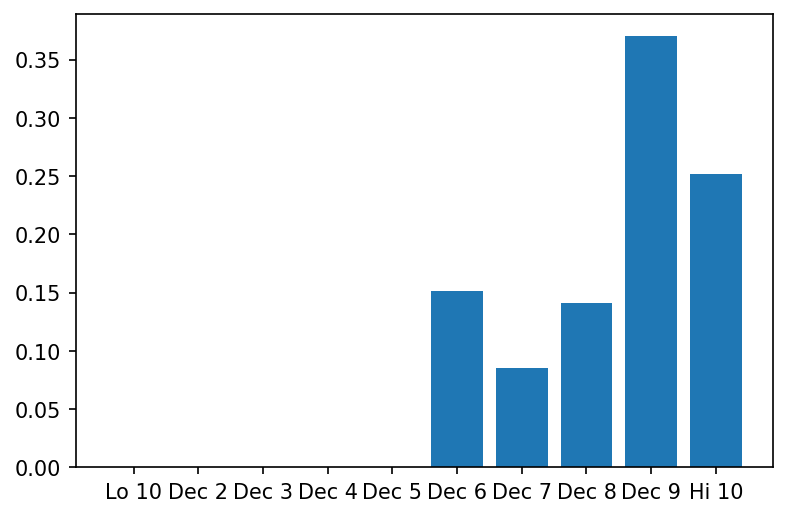

In [12]:
print('Before 2007-2008 financial crisis, Portfolio weight and RF weight are', best_w_p_b07,'and', best_w_rf_b07, 'respectively.')
print('Portfolio weight from Lo 10 to Hi 10 are', mv_weight_b07)

plt.bar(dfr.columns, mv_weight_b07)

After 2007-2008 financial crisis, Portfolio weight and RF weight are 0.841 and 0.15900000000000003 respectively.
Portfolio weight from Lo 10 to Hi 10 are [0.     0.0166 0.7591 0.     0.2087 0.     0.0156 0.     0.     0.    ]


<BarContainer object of 10 artists>

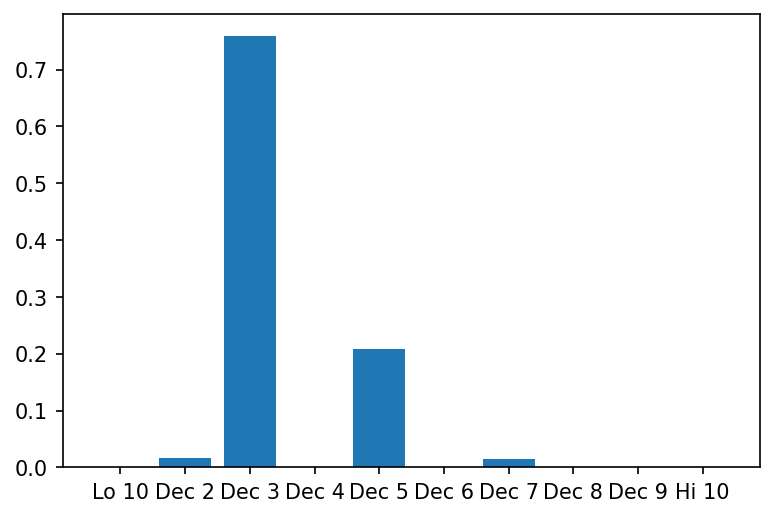

In [13]:
print('After 2007-2008 financial crisis, Portfolio weight and RF weight are', best_w_p_a07,'and', best_w_rf_a07, 'respectively.')
print('Portfolio weight from Lo 10 to Hi 10 are', mv_weight_a07)
plt.bar(dfr.columns, mv_weight_a07)

### Weight Analysis
Before financial crisis, to match BRK's return, the replicated portfolio needs to concentrate more on higher book-to-market ratio stocks, and the portfolio's return is not high enough to beat Warren Buffett, we even need to borrow money and use leverage to increase the return. However, after the financial crisis, no need to borrow money again and we can have some money to lend out. The portfolio weight was more concentrated to lower book-to-market ratio stocks.

Berkshire's investing style diverted from aggressive to relatively conservative, they kept a significant amount of cash in case of extreme market condition happens.

In [14]:
def plot_cumulative_return(r):
    (1 + r).cumprod().plot()
    plt.title('Cumulative Return on $1 Investment')
    plt.ylabel('Cumulative Return ($)')
    plt.axhline(1, color='k', linestyle='--')
    plt.show()
    return None

def plot_underwater(r):
    (100 * drawdown(r)).plot()
    plt.title('Underwater Plot')
    plt.ylabel('Drawdown (%)')
    plt.show()
    return None

def tear_sheet(r, plots=True):
    dic = {
        'Annual Return': annual_return(r),
        'Total Return': total_return(r),
        'Annual Volatility': annual_volatility(r),
        'Sharpe Ratio': sharpe_ratio(r),
        'Calmar Ratio': calmar_ratio(r),
        # 'Stability': stability(r),
        'Max Drawdown': max_drawdown(r),
        # 'Omega Ratio': omega_ratio(r),
        'Sortino Ratio': sortino_ratio(r),
        # 'Skew': skew(r),
        # 'Kurtosis': kurtosis(r),
        # 'Tail Ratio': tail_ratio(r),
        # 'Daily Value at Risk': daily_value_at_risk(r)
    }
    df = pd.DataFrame(data=dic.values(), columns = ['Backtest'], index=dic.keys())
    display(df)
    if plots:
        plot_cumulative_return(r)
        plot_underwater(r)
    return None

,Backtest
Annual Return,0.2548
Total Return,543.4411
Annual Volatility,1.3172
Sharpe Ratio,4.3329
Calmar Ratio,0.4396
Max Drawdown,-0.5798
Sortino Ratio,5.3677


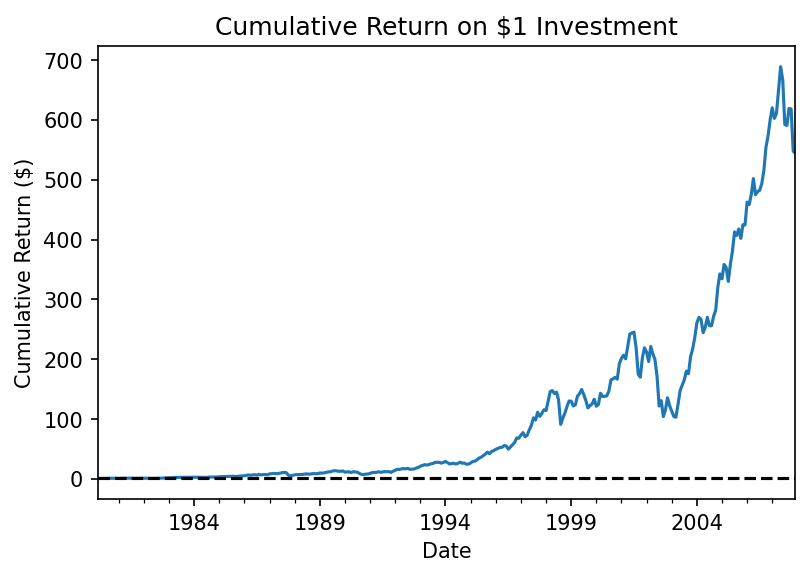

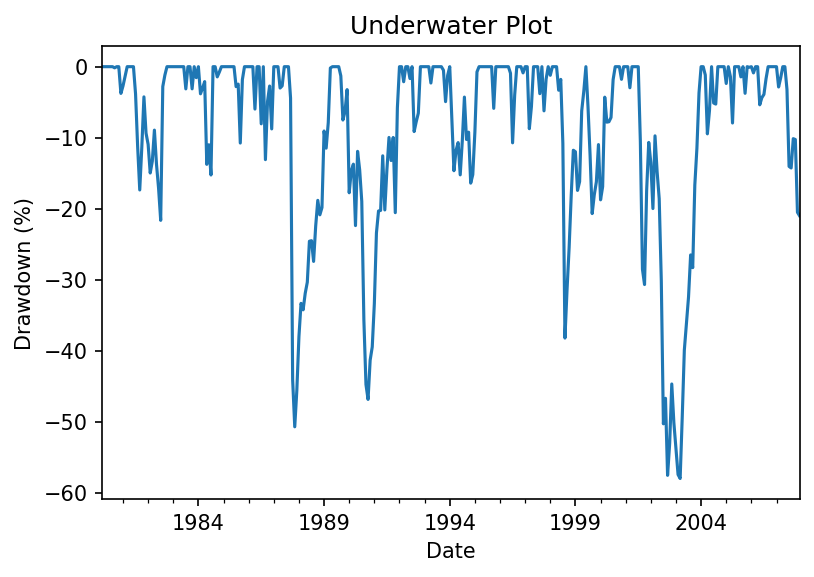

In [15]:
df_rf_portfolio_b07 = pd.DataFrame()
df_rf_portfolio_b07['portfolio'] = portfolio_b07_return
df_rf_portfolio_b07['rf'] = dfrf_b07
rf_portfolio_weight_b07 = np.asarray([best_w_p_b07, best_w_rf_b07])
rf_portfolio_b07_return = df_rf_portfolio_b07.dot(rf_portfolio_weight_b07)

tear_sheet(rf_portfolio_b07_return)

,Backtest
Annual Return,0.2549
Total Return,543.6154
Annual Volatility,1.0884
Sharpe Ratio,4.9435
Calmar Ratio,0.5817
Max Drawdown,-0.4381
Sortino Ratio,8.7545


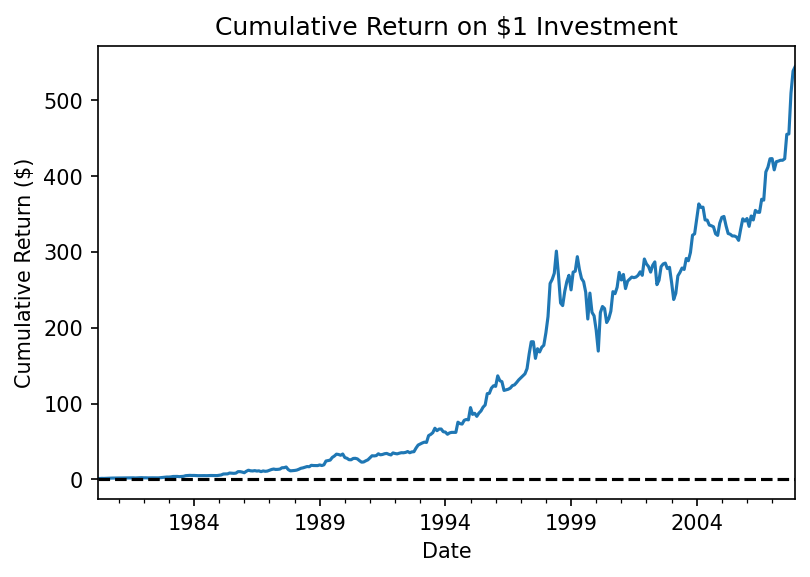

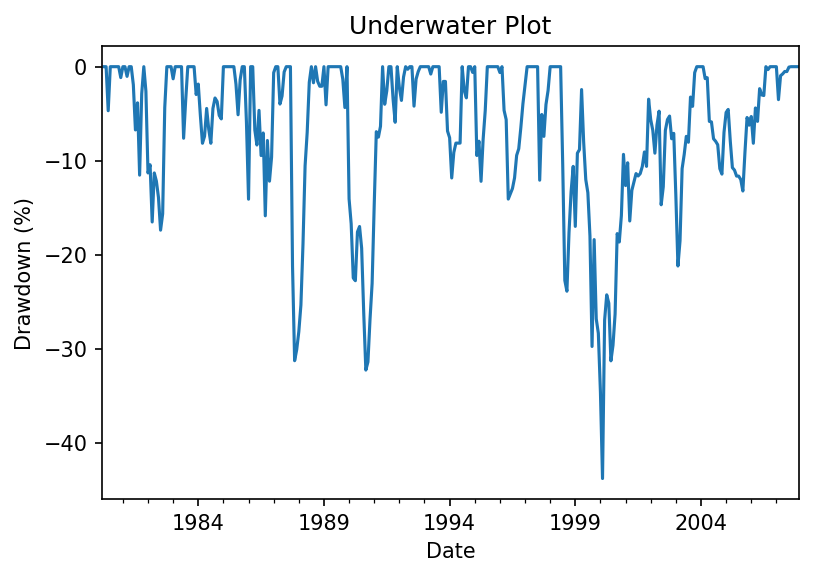

In [16]:
tear_sheet(brk_monthly_b07['ret'])

,Backtest
Annual Return,0.0907
Total Return,2.3940
Annual Volatility,0.5832
Sharpe Ratio,3.4100
Calmar Ratio,0.2391
Max Drawdown,-0.3792
Sortino Ratio,4.4106


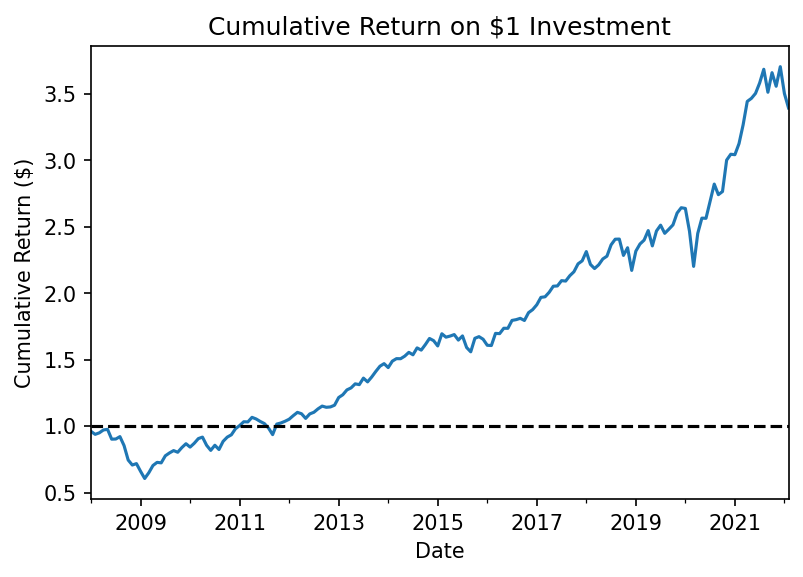

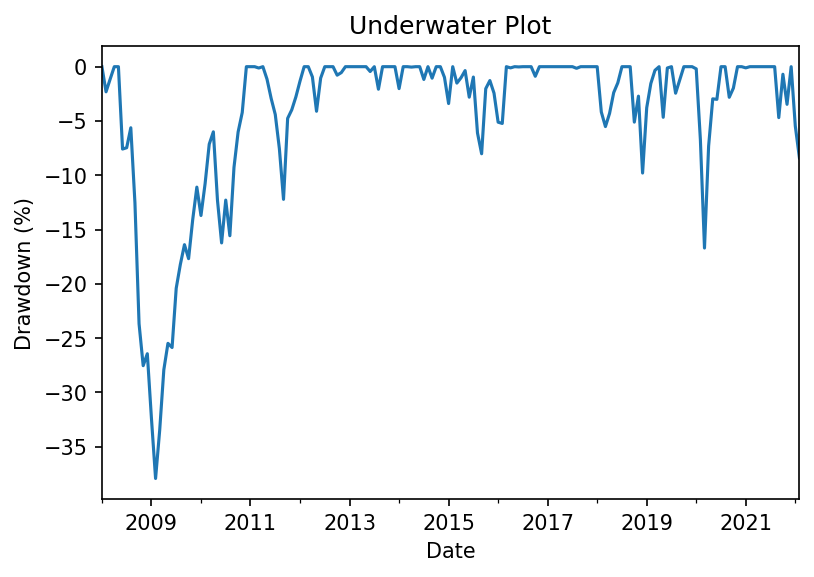

In [17]:
df_rf_portfolio_a07 = pd.DataFrame()
df_rf_portfolio_a07['portfolio'] = portfolio_a07_return
df_rf_portfolio_a07['rf'] = dfrf_a07
rf_portfolio_weight_a07 = np.asarray([best_w_p_a07, best_w_rf_a07])
rf_portfolio_a07_return = df_rf_portfolio_a07.dot(rf_portfolio_weight_a07)

tear_sheet(rf_portfolio_a07_return)

,Backtest
Annual Return,0.0890
Total Return,2.3921
Annual Volatility,0.8109
Sharpe Ratio,2.6013
Calmar Ratio,0.2029
Max Drawdown,-0.4386
Sortino Ratio,4.6183


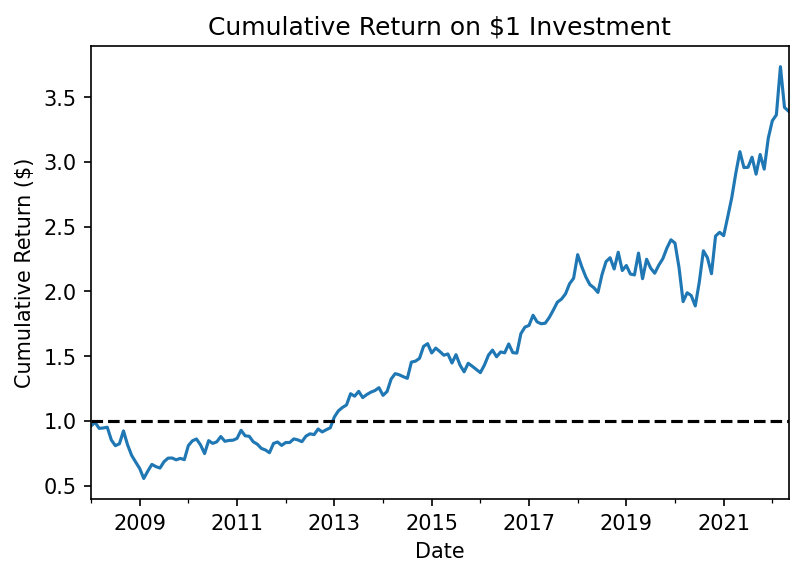

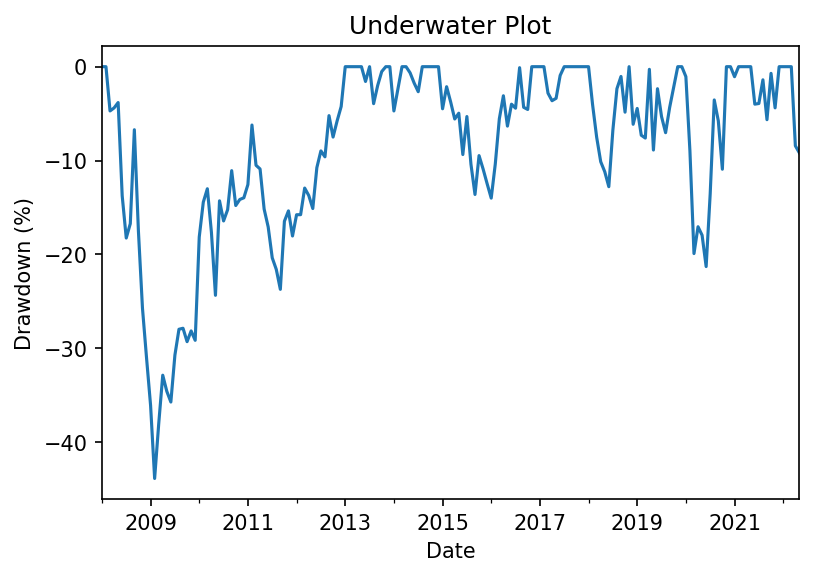

In [18]:
tear_sheet(brk_monthly_a07['ret'])

### Comparison

Before 2007, BRK’s performance was extraordinary, the replication portfolio can match their return but the volatility and risk were higher than BRK. Plus, we need to take leverage and borrow money from market to increase our return to match BRK’s return before financial crisis. However, after the crisis we did not need to borrow money anymore to compete BRK’s return, and the replication portfolio has a less volatility and higher Sharpe and Sortino ratio than BRK’s.

In [19]:
# BRK 5 year rolling window
annual_return_rolling5y = []
sharpe_ratio_rolling5y = []
calmar_ratio_rolling5y = []
mdd_rolling5y = []
sortino_ratio_rolling5y = []

for i in range(60, len(brk_monthly)):
    start = i - 60
    end = i
    window_brk_monthly = brk_monthly.iloc[start:end]['ret']
    annual_return_rolling5y.append(annual_return(window_brk_monthly))
    sharpe_ratio_rolling5y.append(sharpe_ratio(window_brk_monthly))
    calmar_ratio_rolling5y.append(calmar_ratio(window_brk_monthly))
    mdd_rolling5y.append((max_drawdown(window_brk_monthly)))
    sortino_ratio_rolling5y.append((sortino_ratio(window_brk_monthly)))

df_BRK_5y = pd.DataFrame()
df_BRK_5y.index = brk_monthly.index[60:]
df_BRK_5y['time'] = df_BRK_5y.index
df_BRK_5y['annual_return'] = annual_return_rolling5y
df_BRK_5y['sharpe_ratio'] = sharpe_ratio_rolling5y
df_BRK_5y['calmar_ratio'] = calmar_ratio_rolling5y
df_BRK_5y['max_drawdown'] = mdd_rolling5y
df_BRK_5y['sortino_ratio'] = sortino_ratio_rolling5y

df_BRK_5y

,time,annual_return,sharpe_ratio,calmar_ratio,max_drawdown,sortino_ratio
Date,,,,,,
1985-03-31,1985-03-31,0.4265,7.5101,2.4526,-0.1739,20.0146
1985-04-30,1985-04-30,0.4846,7.8233,2.7867,-0.1739,21.9407
1985-05-31,1985-05-31,0.4738,7.6849,2.7246,-0.1739,21.5428
1985-06-30,1985-06-30,0.4304,7.2983,2.4746,-0.1739,19.9036
1985-07-31,1985-07-31,0.4879,7.9522,2.8056,-0.1739,21.6442
...,...,...,...,...,...,...
2022-01-31,2022-01-31,0.1329,3.6061,0.6241,-0.2129,6.6865
2022-02-28,2022-02-28,0.1405,3.7765,0.6599,-0.2129,7.0236
2022-03-31,2022-03-31,0.1336,3.6255,0.6277,-0.2129,6.7182


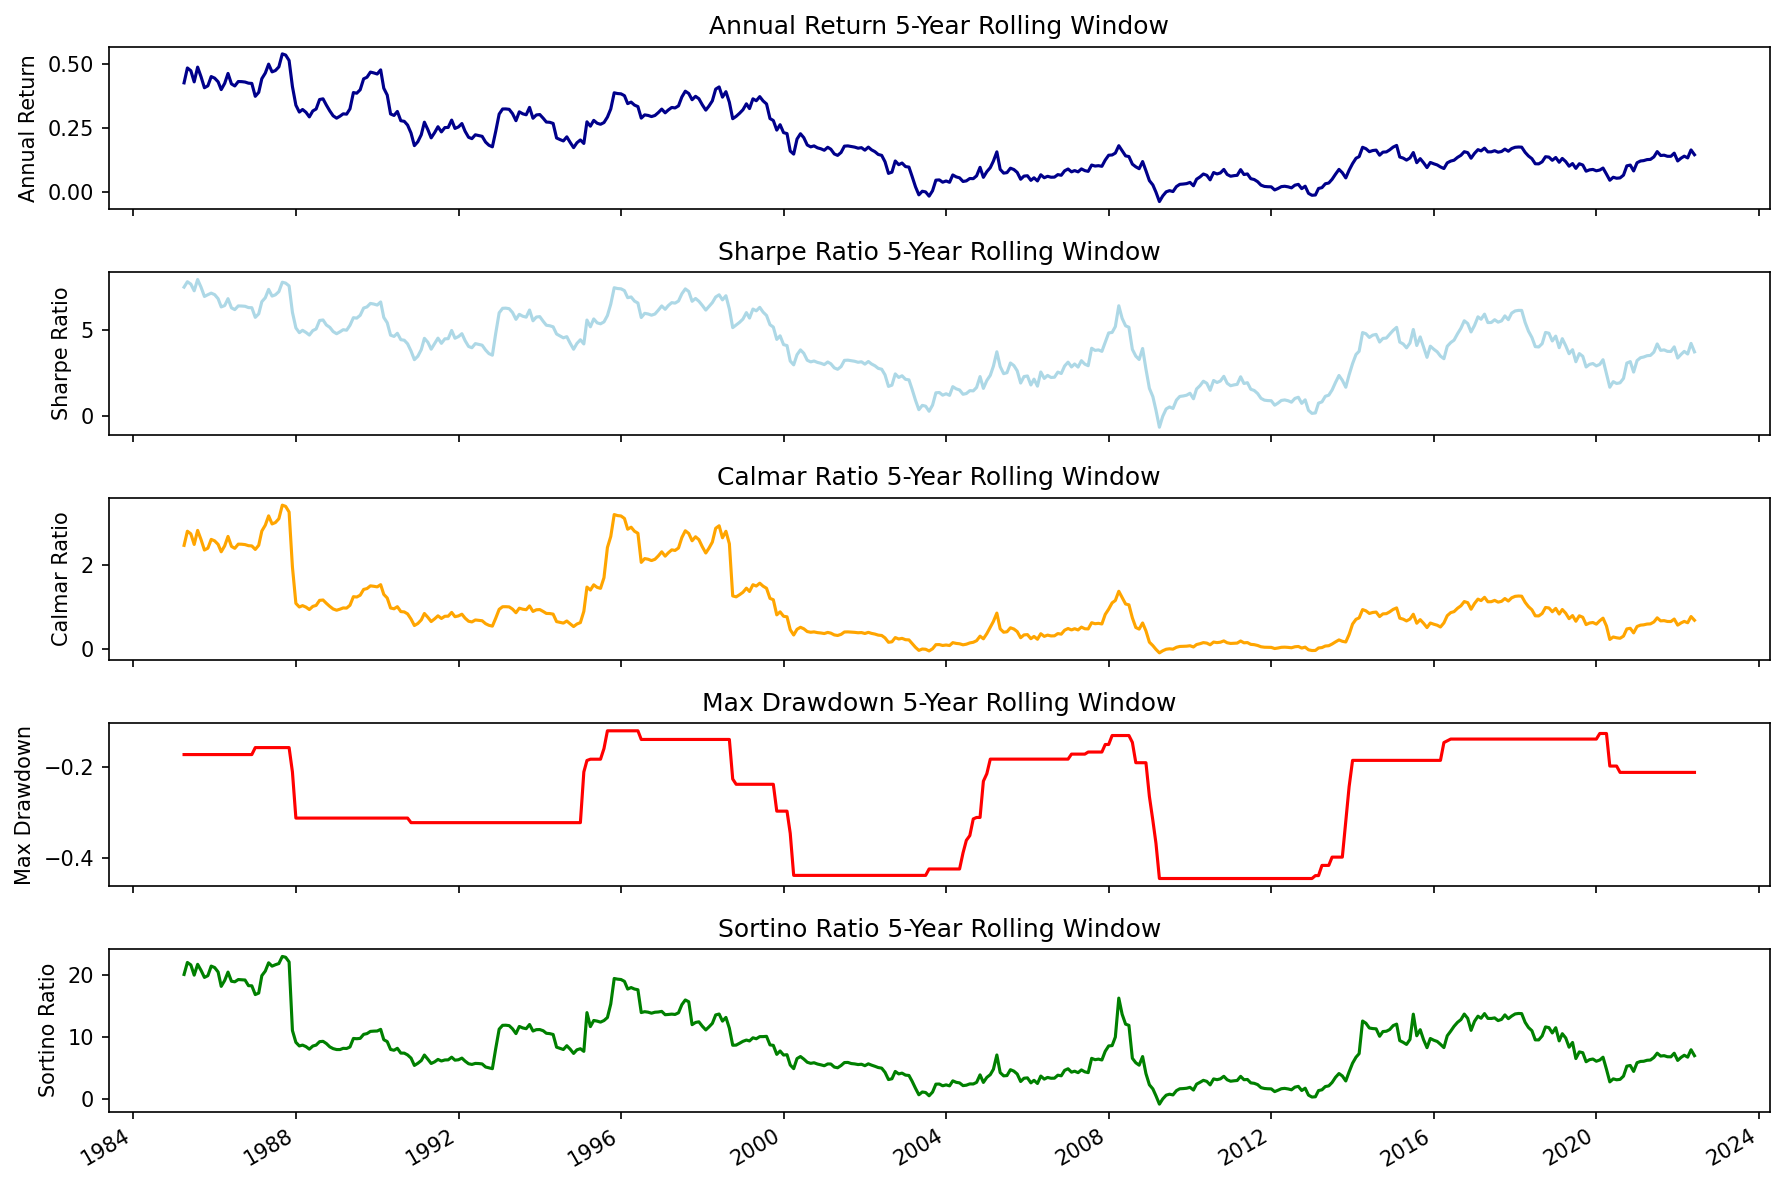

In [20]:
# plot
fig = plt.figure(figsize=(12.0, 8.0))
ax1 = plt.subplot(511)
ax1.plot(df_BRK_5y['time'], df_BRK_5y['annual_return'], c='darkblue')
fig.autofmt_xdate()
ax1.set_ylabel('Annual Return')
plt.title('Annual Return 5-Year Rolling Window')
plt.tight_layout()

ax2 = plt.subplot(512)
ax2.plot(df_BRK_5y['time'], df_BRK_5y['sharpe_ratio'], c='lightblue')
fig.autofmt_xdate()
ax2.set_ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio 5-Year Rolling Window')
plt.tight_layout()

ax3 = plt.subplot(513)
ax3.plot(df_BRK_5y['time'], df_BRK_5y['calmar_ratio'], c='orange')
fig.autofmt_xdate()
ax3.set_ylabel('Calmar Ratio')
plt.title('Calmar Ratio 5-Year Rolling Window')
plt.tight_layout()

ax4 = plt.subplot(514)
ax4.plot(df_BRK_5y['time'], df_BRK_5y['max_drawdown'], c='red')
fig.autofmt_xdate()
ax4.set_ylabel('Max Drawdown')
plt.title('Max Drawdown 5-Year Rolling Window')
plt.tight_layout()

ax5 = plt.subplot(515)
ax5.plot(df_BRK_5y['time'], df_BRK_5y['sortino_ratio'], c='green')
fig.autofmt_xdate()
ax5.set_ylabel('Sortino Ratio')
plt.title('Sortino Ratio 5-Year Rolling Window')
plt.tight_layout()

### Repeatability

The 5-year rolling window plots showed the repeatability is generally good but not excellent. Annual return swings from near 50% to less than 10%. Earlier years were easier to obtain higher return, and the Sharpe ratio and Sortino ratio were also very high. After 2007-2008 financial crisis, the BRK’s stock return dropped significantly. There were mainly 3 golden period, pre-1988, 1996-2000, and 2014-2020. Returns were high and drawdowns were low during these 3 periods, but generally the returns kept going down even in the golden period, the 2014-2020 was the weakest golden period among all 3. BRK was and is strong, but it also became harder to repeat the performance itself.

AttributeError: 'collections.OrderedDict' object has no attribute 'right'

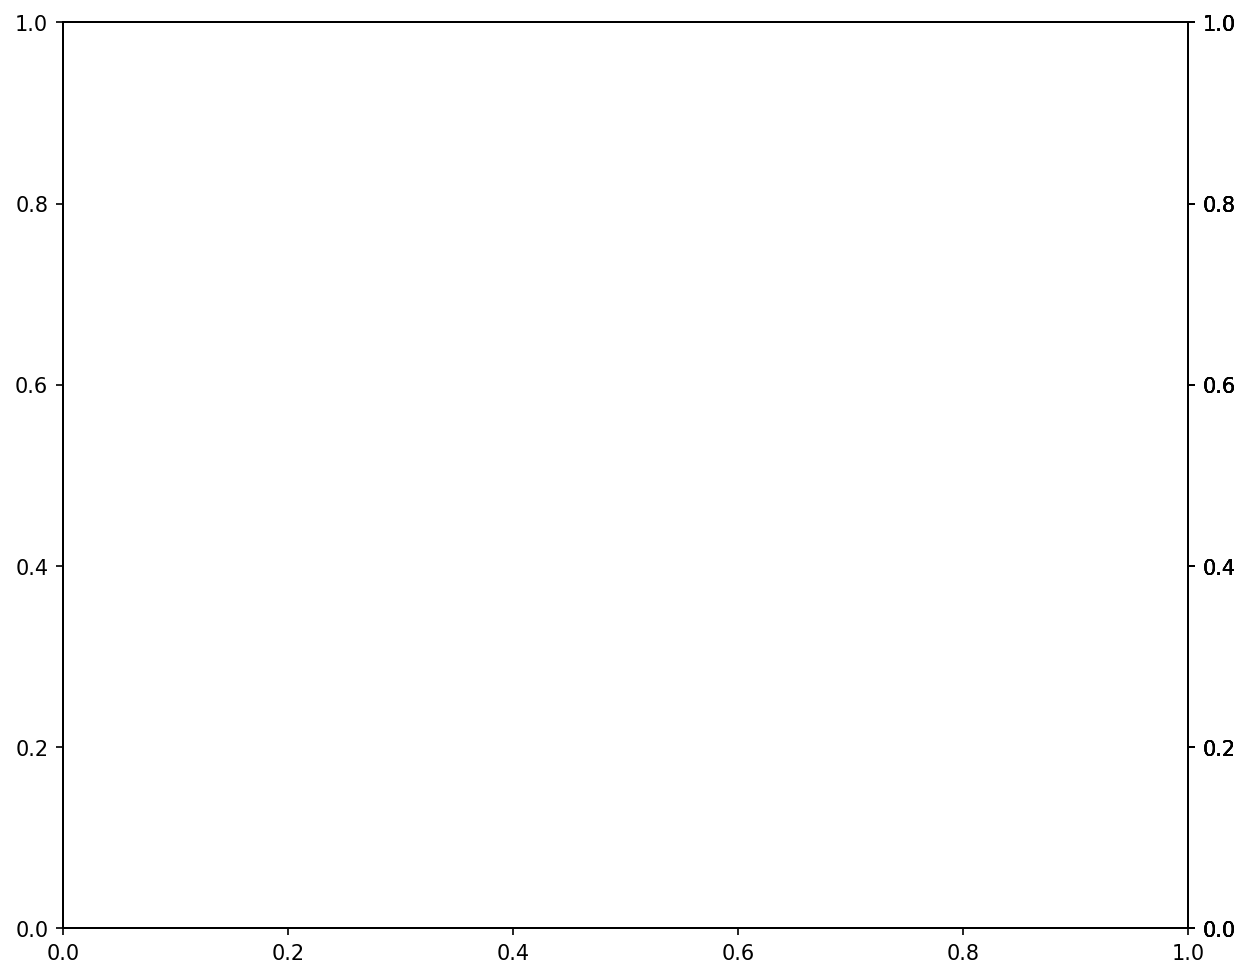

In [21]:
fig, ax = plt.subplots(figsize=(12.0, 8.0))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()
twin4 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.1))
twin3.spines.right.set_position(("axes", 1.2))
twin4.spines.right.set_position(("axes", 1.3))

p1, = ax.plot(df_BRK_5y['time'], df_BRK_5y['annual_return'], "b-", label="Annual Return")
p2, = twin1.plot(df_BRK_5y['time'], df_BRK_5y['sharpe_ratio'], "r-", label="Sharpe Ratio")
p3, = twin2.plot(df_BRK_5y['time'], df_BRK_5y['calmar_ratio'], "g-", label="Calmar Ratio")
p4, = twin3.plot(df_BRK_5y['time'], df_BRK_5y['max_drawdown'], "k-", label="Max Drawdown")
p5, = twin4.plot(df_BRK_5y['time'], df_BRK_5y['sortino_ratio'], "m-", label="Sortino Ratio")

ax.set_xlabel("Time")
ax.set_ylabel("Annual Return")
twin1.set_ylabel("Sharpe Ratio")
twin2.set_ylabel("Calmar Ratio")
twin3.set_ylabel("Max Drawdown")
twin4.set_ylabel("Sortino Ratio")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())
twin3.yaxis.label.set_color(p4.get_color())
twin4.yaxis.label.set_color(p5.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
twin3.tick_params(axis='y', colors=p4.get_color(), **tkw)
twin4.tick_params(axis='y', colors=p5.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3, p4, p5])